# Celosia - Experiment to demonstrate detection of zero-day attacks

In [1]:
# Imports
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.python.client import device_lib
import time
import seaborn as sns
import matplotlib.gridspec as gridspec

from keras.layers import Input, Dense
from keras import regularizers, Model
from keras.models import Sequential

from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, precision_recall_curve, classification_report, confusion_matrix, average_precision_score, roc_curve, auc

Using TensorFlow backend.


In [2]:
# Make sure that the dataset exists
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

In [3]:
# Importing benign gafgyt combo dataset for a given device id (1-9)
def import_dataset_benign_gagfyt_combo(device_id):
    normal = pd.read_csv('../input/nbaiot-dataset/{}.benign.csv'.format(device_id))
    n_X = normal.iloc[:,]
    n_X_scaled = MinMaxScaler().fit_transform(n_X.values)
    n_y = np.ones(n_X.shape[0]) # 1 represents normal

    anomalous = pd.read_csv('../input/nbaiot-dataset/{}.gafgyt.combo.csv'.format(device_id))
    a_X = anomalous.iloc[:,]
    a_X_scaled = MinMaxScaler().fit_transform(a_X.values)
    a_y = np.ones(a_X.shape[0]) # 1 represents normal

    #normal.info()
    #normal.describe()
    #normal.head()

    #anomalous.info()
    #anomalous.describe()
    #anomalous.head()

    return (n_X_scaled, n_y, a_X_scaled, a_y)

In [4]:
# AutoEncoder

def generate_and_train_autoencoder(X):
    ## input layer 
    input_layer = Input(shape=(X.shape[1],))

    ## encoding part
    encoded = Dense(100, activation='tanh', activity_regularizer=regularizers.l1(10e-5))(input_layer)
    encoded = Dense(50, activation='relu')(encoded)

    ## decoding part
    decoded = Dense(50, activation='tanh')(encoded)
    decoded = Dense(100, activation='tanh')(decoded)

    ## output layer
    output_layer = Dense(X.shape[1], activation='relu')(decoded)

    autoencoder = Model(input_layer, output_layer)
    autoencoder.compile(optimizer="adadelta", loss="mse")

    autoencoder.fit(X[0:1000], X[0:1000], 
                    batch_size = 256, epochs = 10, 
                    shuffle = True, validation_split = 0.20);

    return autoencoder

In [5]:
# hidden representation
def get_hidden_representation_normal_anomalous(autoencoder, n_X, a_X):
    hidden_representation = Sequential()
    hidden_representation.add(autoencoder.layers[0])
    hidden_representation.add(autoencoder.layers[1])
    hidden_representation.add(autoencoder.layers[2])

    normal_hid_rep = hidden_representation.predict(n_X[:3000])
    anomalous_hid_rep = hidden_representation.predict(a_X[:3000])

    return (normal_hid_rep, anomalous_hid_rep)

In [6]:
def tsne_plot(x, y, title="Scatter Plot", name="graph.png"):
    tsne = TSNE(n_components=2, random_state=0)
    X_t = tsne.fit_transform(x)

    plt.figure(figsize=(12, 8))
    plt.scatter(X_t[np.where(y == 1), 0], X_t[np.where(y == 1), 1], marker='o', color='g', linewidth='1', alpha=0.8, label='Normal')
    plt.scatter(X_t[np.where(y == 0), 0], X_t[np.where(y == 0), 1], marker='o', color='r', linewidth='1', alpha=0.8, label='Anomalous')

    plt.title(title)
    plt.legend(loc='best');
    plt.savefig('{}-{}'.format(title,name));
    plt.show();

In [7]:
# Combine normal and anomalous data
def combine_normal_anomalous(normal, anomalous):
    X = np.append(normal, anomalous, axis = 0)
    y_n = np.ones(normal.shape[0])
    y_a = np.zeros(anomalous.shape[0])
    y = np.append(y_n, y_a)

    return (X, y)

In [8]:
# Evaluate model's performace
def evaluate_model(X, y):
    train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.25)
    clf = LogisticRegression(solver="lbfgs").fit(train_X, train_y)
    pred_y = clf.predict(test_X)
    return (test_y, pred_y)

In [9]:
# Show model's report
def show_model_report(title, X, y, hid_X, hid_y, test_y, pred_y):
    #tsne_plot(X, y, '{}-original'.format(title), "original.png")
    tsne_plot(hid_X, hid_y, title, "hidden_representation.png")

    print(title)
    print ("")
    print ("Classification Report: ")
    print (classification_report(test_y, pred_y))

    print ("")
    print ("Accuracy Score: ", accuracy_score(test_y, pred_y))

In [10]:
# Detect zero-day attack
def detect_zero_day_attack(device_name, device_id):
    (n_X_scaled, n_y, a_X_scaled, a_y) = import_dataset_benign_gagfyt_combo(device_id)
    autoencoder = generate_and_train_autoencoder(n_X_scaled)
    (normal_hid_rep, anomalous_hid_rep) = get_hidden_representation_normal_anomalous(autoencoder, n_X_scaled, a_X_scaled)
    (X, y) = combine_normal_anomalous(n_X_scaled, a_X_scaled)
    (hid_X, hid_y) = combine_normal_anomalous(normal_hid_rep, anomalous_hid_rep)
    (test_y, pred_y) = evaluate_model(hid_X, hid_y)
    show_model_report(device_name, X, y, hid_X, hid_y, test_y, pred_y)

Train on 800 samples, validate on 200 samples
Epoch 1/10
800/800 [==============================] - 0s 569us/step - loss: 0.4767 - val_loss: 0.3180
Epoch 2/10
800/800 [==============================] - 0s 23us/step - loss: 0.3639 - val_loss: 0.2353
Epoch 3/10
800/800 [==============================] - 0s 23us/step - loss: 0.2743 - val_loss: 0.1760
Epoch 4/10
800/800 [==============================] - 0s 22us/step - loss: 0.2136 - val_loss: 0.1357
Epoch 5/10
800/800 [==============================] - 0s 22us/step - loss: 0.1730 - val_loss: 0.1112
Epoch 6/10
800/800 [==============================] - 0s 21us/step - loss: 0.1505 - val_loss: 0.0947
Epoch 7/10
800/800 [==============================] - 0s 22us/step - loss: 0.1315 - val_loss: 0.0823
Epoch 8/10
800/800 [==============================] - 0s 21us/step - loss: 0.1198 - val_loss: 0.0733
Epoch 9/10
800/800 [==============================] - 0s 22us/step - loss: 0.1085 - val_loss: 0.0667
Epoch 10/10
800/800 [=======================

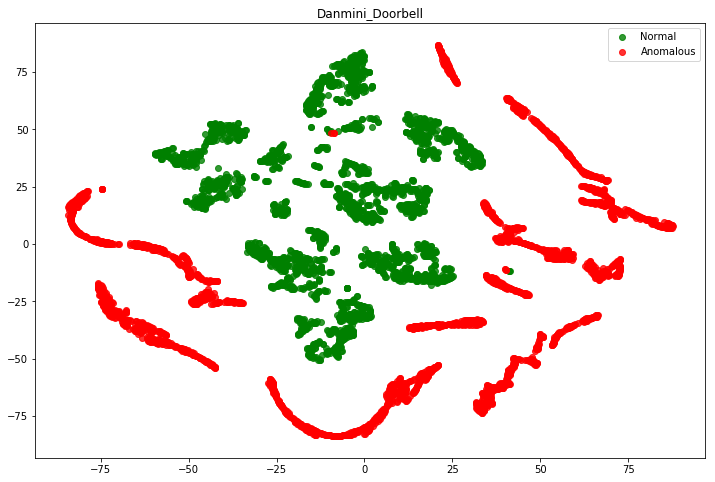

Danmini_Doorbell

Classification Report: 
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       735
         1.0       1.00      1.00      1.00       765

    accuracy                           1.00      1500
   macro avg       1.00      1.00      1.00      1500
weighted avg       1.00      1.00      1.00      1500


Accuracy Score:  1.0
Train on 800 samples, validate on 200 samples
Epoch 1/10
800/800 [==============================] - 0s 275us/step - loss: 0.6400 - val_loss: 0.4114
Epoch 2/10
800/800 [==============================] - 0s 23us/step - loss: 0.4711 - val_loss: 0.2942
Epoch 3/10
800/800 [==============================] - 0s 21us/step - loss: 0.3520 - val_loss: 0.2249
Epoch 4/10
800/800 [==============================] - 0s 21us/step - loss: 0.2826 - val_loss: 0.1856
Epoch 5/10
800/800 [==============================] - 0s 21us/step - loss: 0.2444 - val_loss: 0.1629
Epoch 6/10
800/800 [==============================] - 0s 

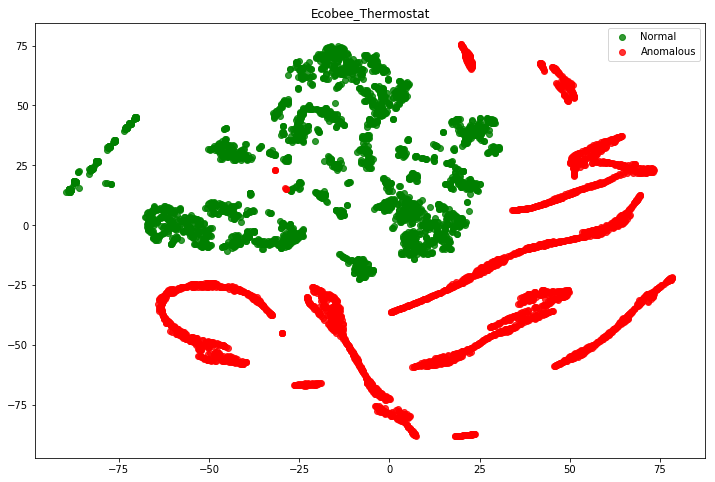

Ecobee_Thermostat

Classification Report: 
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       752
         1.0       1.00      1.00      1.00       748

    accuracy                           1.00      1500
   macro avg       1.00      1.00      1.00      1500
weighted avg       1.00      1.00      1.00      1500


Accuracy Score:  1.0
Train on 800 samples, validate on 200 samples
Epoch 1/10
800/800 [==============================] - 0s 276us/step - loss: 0.5808 - val_loss: 0.3891
Epoch 2/10
800/800 [==============================] - 0s 23us/step - loss: 0.4456 - val_loss: 0.2941
Epoch 3/10
800/800 [==============================] - 0s 23us/step - loss: 0.3426 - val_loss: 0.2251
Epoch 4/10
800/800 [==============================] - 0s 23us/step - loss: 0.2692 - val_loss: 0.1757
Epoch 5/10
800/800 [==============================] - 0s 22us/step - loss: 0.2168 - val_loss: 0.1417
Epoch 6/10
800/800 [==============================] - 0s

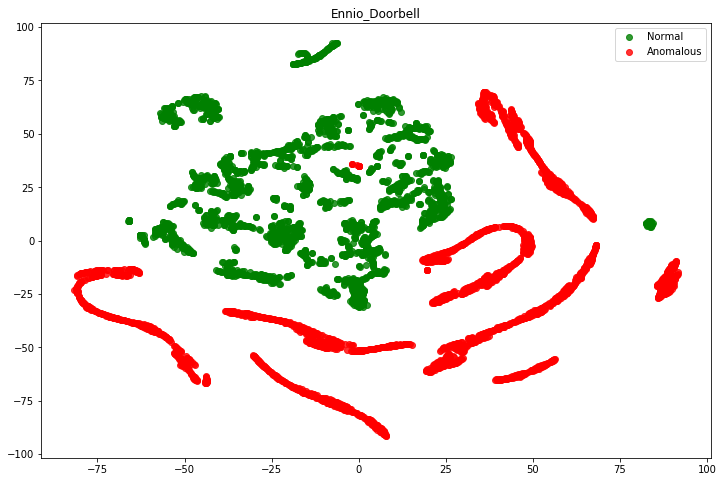

Ennio_Doorbell

Classification Report: 
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       757
         1.0       1.00      1.00      1.00       743

    accuracy                           1.00      1500
   macro avg       1.00      1.00      1.00      1500
weighted avg       1.00      1.00      1.00      1500


Accuracy Score:  0.9993333333333333
Train on 800 samples, validate on 200 samples
Epoch 1/10
800/800 [==============================] - 0s 276us/step - loss: 1.1758 - val_loss: 0.7260
Epoch 2/10
800/800 [==============================] - 0s 22us/step - loss: 0.7973 - val_loss: 0.6689
Epoch 3/10
800/800 [==============================] - 0s 21us/step - loss: 0.5484 - val_loss: 0.6324
Epoch 4/10
800/800 [==============================] - 0s 21us/step - loss: 0.4329 - val_loss: 0.6183
Epoch 5/10
800/800 [==============================] - 0s 21us/step - loss: 0.3904 - val_loss: 0.6100
Epoch 6/10
800/800 [========================

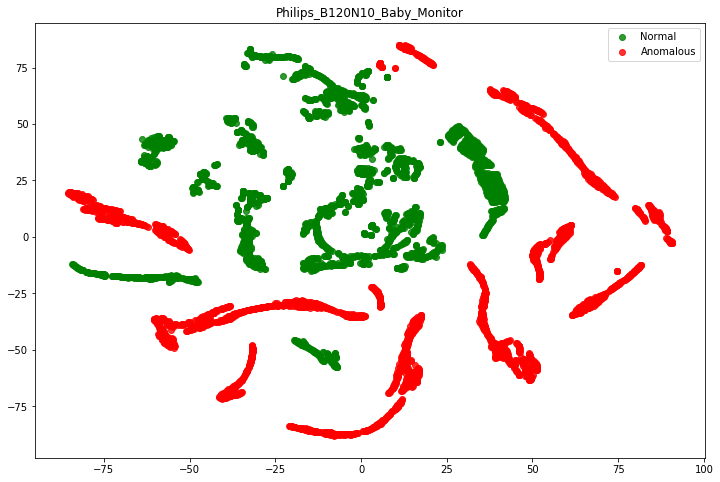

Philips_B120N10_Baby_Monitor

Classification Report: 
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       740
         1.0       1.00      1.00      1.00       760

    accuracy                           1.00      1500
   macro avg       1.00      1.00      1.00      1500
weighted avg       1.00      1.00      1.00      1500


Accuracy Score:  1.0
Train on 800 samples, validate on 200 samples
Epoch 1/10
800/800 [==============================] - 0s 273us/step - loss: 0.5157 - val_loss: 0.2556
Epoch 2/10
800/800 [==============================] - 0s 22us/step - loss: 0.4206 - val_loss: 0.2095
Epoch 3/10
800/800 [==============================] - 0s 21us/step - loss: 0.3479 - val_loss: 0.1742
Epoch 4/10
800/800 [==============================] - 0s 22us/step - loss: 0.2975 - val_loss: 0.1458
Epoch 5/10
800/800 [==============================] - 0s 21us/step - loss: 0.2596 - val_loss: 0.1228
Epoch 6/10
800/800 [=========================

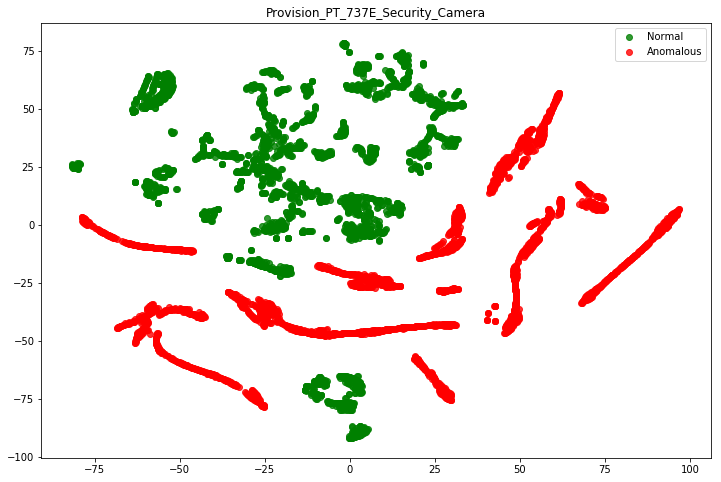

Provision_PT_737E_Security_Camera

Classification Report: 
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       742
         1.0       1.00      1.00      1.00       758

    accuracy                           1.00      1500
   macro avg       1.00      1.00      1.00      1500
weighted avg       1.00      1.00      1.00      1500


Accuracy Score:  1.0
Train on 800 samples, validate on 200 samples
Epoch 1/10
800/800 [==============================] - 0s 284us/step - loss: 0.5257 - val_loss: 0.3801
Epoch 2/10
800/800 [==============================] - 0s 25us/step - loss: 0.4262 - val_loss: 0.3091
Epoch 3/10
800/800 [==============================] - 0s 22us/step - loss: 0.3511 - val_loss: 0.2577
Epoch 4/10
800/800 [==============================] - 0s 22us/step - loss: 0.2971 - val_loss: 0.2219
Epoch 5/10
800/800 [==============================] - 0s 23us/step - loss: 0.2569 - val_loss: 0.1951
Epoch 6/10
800/800 [====================

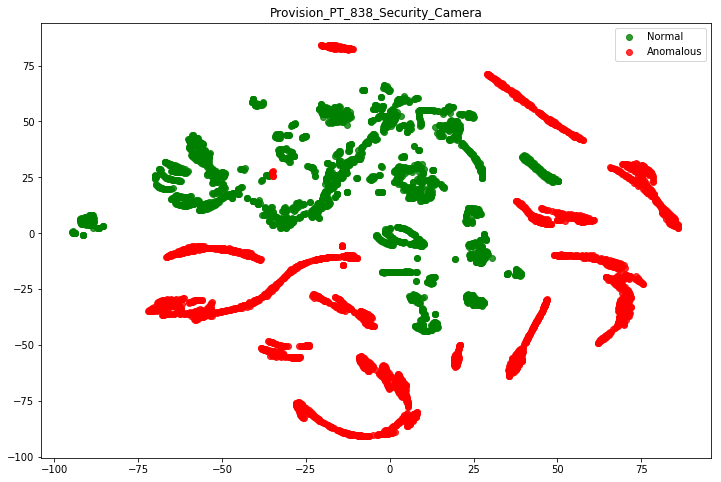

Provision_PT_838_Security_Camera

Classification Report: 
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       755
         1.0       1.00      1.00      1.00       745

    accuracy                           1.00      1500
   macro avg       1.00      1.00      1.00      1500
weighted avg       1.00      1.00      1.00      1500


Accuracy Score:  1.0
Train on 800 samples, validate on 200 samples
Epoch 1/10
800/800 [==============================] - 0s 287us/step - loss: 0.5307 - val_loss: 0.3423
Epoch 2/10
800/800 [==============================] - 0s 25us/step - loss: 0.4018 - val_loss: 0.2489
Epoch 3/10
800/800 [==============================] - 0s 23us/step - loss: 0.3086 - val_loss: 0.1887
Epoch 4/10
800/800 [==============================] - 0s 24us/step - loss: 0.2501 - val_loss: 0.1540
Epoch 5/10
800/800 [==============================] - 0s 23us/step - loss: 0.2167 - val_loss: 0.1331
Epoch 6/10
800/800 [=====================

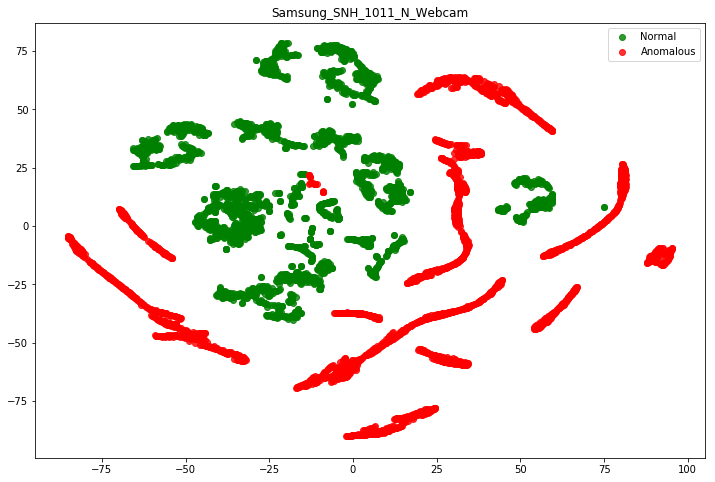

Samsung_SNH_1011_N_Webcam

Classification Report: 
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       773
         1.0       1.00      1.00      1.00       727

    accuracy                           1.00      1500
   macro avg       1.00      1.00      1.00      1500
weighted avg       1.00      1.00      1.00      1500


Accuracy Score:  0.9973333333333333
Train on 800 samples, validate on 200 samples
Epoch 1/10
800/800 [==============================] - 0s 276us/step - loss: 0.6339 - val_loss: 0.4810
Epoch 2/10
800/800 [==============================] - 0s 22us/step - loss: 0.5078 - val_loss: 0.4041
Epoch 3/10
800/800 [==============================] - 0s 22us/step - loss: 0.4207 - val_loss: 0.3479
Epoch 4/10
800/800 [==============================] - 0s 23us/step - loss: 0.3580 - val_loss: 0.3061
Epoch 5/10
800/800 [==============================] - 0s 23us/step - loss: 0.3101 - val_loss: 0.2732
Epoch 6/10
800/800 [=============

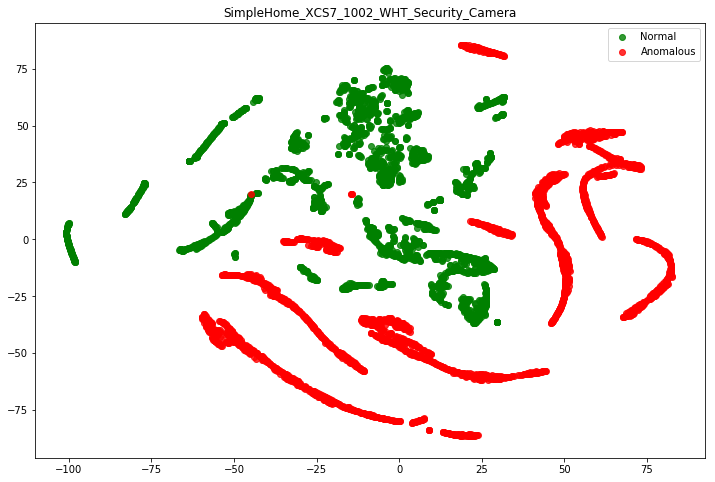

SimpleHome_XCS7_1002_WHT_Security_Camera

Classification Report: 
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       731
         1.0       1.00      1.00      1.00       769

    accuracy                           1.00      1500
   macro avg       1.00      1.00      1.00      1500
weighted avg       1.00      1.00      1.00      1500


Accuracy Score:  1.0
Train on 800 samples, validate on 200 samples
Epoch 1/10
800/800 [==============================] - 0s 293us/step - loss: 0.5769 - val_loss: 0.3413
Epoch 2/10
800/800 [==============================] - 0s 28us/step - loss: 0.4437 - val_loss: 0.2528
Epoch 3/10
800/800 [==============================] - 0s 28us/step - loss: 0.3526 - val_loss: 0.1957
Epoch 4/10
800/800 [==============================] - 0s 39us/step - loss: 0.2950 - val_loss: 0.1593
Epoch 5/10
800/800 [==============================] - 0s 25us/step - loss: 0.2572 - val_loss: 0.1320
Epoch 6/10
800/800 [=============

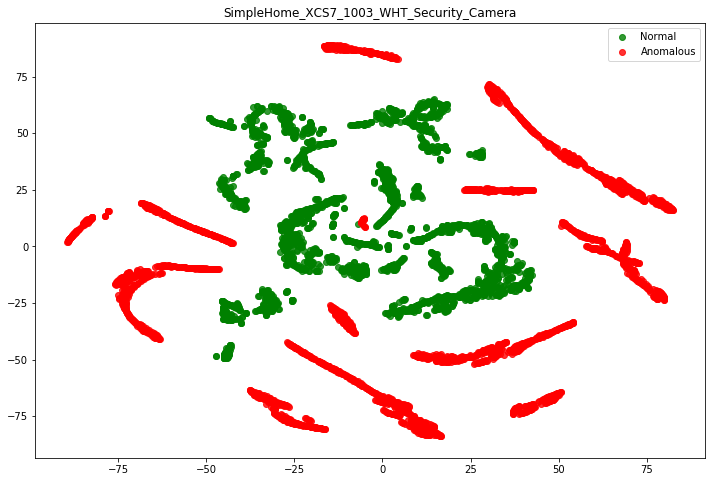

SimpleHome_XCS7_1003_WHT_Security_Camera

Classification Report: 
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       742
         1.0       1.00      1.00      1.00       758

    accuracy                           1.00      1500
   macro avg       1.00      1.00      1.00      1500
weighted avg       1.00      1.00      1.00      1500


Accuracy Score:  1.0


In [11]:
devices = ['Danmini_Doorbell', 'Ecobee_Thermostat', 'Ennio_Doorbell', 'Philips_B120N10_Baby_Monitor', 'Provision_PT_737E_Security_Camera', 'Provision_PT_838_Security_Camera', 'Samsung_SNH_1011_N_Webcam', 'SimpleHome_XCS7_1002_WHT_Security_Camera', 'SimpleHome_XCS7_1003_WHT_Security_Camera']
#devices = ['Danmini_Doorbell', 'Ecobee_Thermostat']
for device_id, device_name in enumerate(devices, 1):
    detect_zero_day_attack(device_name, device_id)
